In [5]:
from __future__ import division
%matplotlib inline
import sys 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as io
import pickle

import scipy.stats

In [6]:
SBJ = 'EEG25'

In [7]:
#prj_dir = '/Volumes/hoycw_clust/PRJ_Error_eeg/'#'/Users/sheilasteiner/Desktop/Knight_Lab/PRJ_Error_eeg/'
#'/Volumes/hoycw_clust/PRJ_Error/'
prj_dir = '/Users/sheilasteiner/Desktop/Knight_Lab/PRJ_Error_eeg/'
results_dir = prj_dir+'results/'
fig_type = '.svg'
data_dir = prj_dir+'data/'
sbj_dir  = data_dir+SBJ+'/'

### Load paradigm parameters

In [8]:
prdm_fname = os.path.join(sbj_dir,'03_events',SBJ+'_prdm_vars.pkl')
with open(prdm_fname, 'rb') as f:
    prdm = pickle.load(f)

In [9]:
# print 'paradigm: ', prdm['prdm_name'], ' v', prdm['prdm_version']
# print
# print 'interval: ', prdm['target'], 's'
# print 'feedback_delay: ', prdm['fb_delay'], 's'
# print 'feedback duration: ', prdm['fb'], 's'
# print 'total trial length: ', prdm['trl_len'], 's'
# print
# print 'n_blocks: ', prdm['n_blocks']
# print 'n_trials/block: ', prdm['n_trials']
# print 'n_full_vis_examples: ', prdm['n_examples']
# print 'n_training/condition: ', prdm['n_training']
# print
# # ITI_bounds = [np.mean(a,b) for a, b in zip(ITIs[:-1],ITIs[1:])]
# print 'ITIs:',prdm['ITIs']#, ITI_bounds
# print 'tolerance_lim:', prdm['tol_lim']

### Load Log Info

In [10]:
behav_fname = os.path.join(sbj_dir,'03_events',SBJ+'_behav.csv')
data = pd.read_csv(behav_fname)

In [11]:
# Remove second set of training trials in restarted runs (EEG12, EEG24, EEG25)
if len(data[(data['Trial']==0) & (data['Block']==-1)])>1:
    train_start_ix = data[(data['Trial']==0) & (data['Block']==-1)].index
    train_ix = [ix for ix in data.index if data.loc[ix,'Block']==-1]
    later_ix = [ix for ix in data.index if ix >= train_start_ix[1]]
    data = data.drop(set(later_ix).intersection(train_ix))
    data = data.reset_index()

In [12]:
# Change block numbers on EEG12 to not overlap
if SBJ=='EEG12':
    b4_start_ix = data[(data['Trial']==0) & (data['Block']==4)].index
    for ix in range(b4_start_ix[1]):
        if data.loc[ix,'Block']!=-1:
            data.loc[ix,'Block'] = data.loc[ix,'Block']-4

In [13]:
# Label post-correct (PC), post-error (PE) trials
data['PE'] = [False for _ in range(len(data))]
for ix in range(len(data)):
    # Exclude training data and first trial of the block
    if (data.loc[ix,'Block']!=-1) and (data.loc[ix,'Trial']!=0):
        if data.loc[ix-1,'Hit']==0:
            data.loc[ix,'PE'] = True

In [14]:
# pd.set_option('max_rows', 75)
# data[data['Block']==3]

# Add specific analysis computations

In [15]:
print len(block_start_ix)
print len(block_mid_ix)
print len(accuracy)

NameError: name 'block_start_ix' is not defined

In [16]:
# Find middle of blocks to plot accuracy
block_start_ix = data[data['Trial']==0].index
if SBJ=='EP11':#deal with missing BT_T0
    block_mid_ix = [ix+prdm['n_trials']/2 for ix in block_start_ix]
else:
    block_mid_ix = [ix+prdm['n_trials']/2 for ix in block_start_ix[1:]]

# Add in full_vis + E/H training: 0:4 + 5:19 = 10; 20:34 = 27.5 
block_mid_ix.insert(0,np.mean([prdm['n_examples']+prdm['n_training'],
         prdm['n_examples']+2*prdm['n_training']]))   #examples
block_mid_ix.insert(0,np.mean([0, prdm['n_examples']+prdm['n_training']]))
#easy training (would be 12.5 if splitting examples/train)

In [17]:
# Compute accuracy per block
accuracy = data['Hit'].groupby([data['Block'],data['Condition']]).mean()
acc_ITI = data['Hit'].groupby([data['ITI type'],data['Condition']]).mean()
for ix in range(len(data)):
    data.loc[ix,'Accuracy'] = accuracy[data.loc[ix,'Block'],data.loc[ix,'Condition']]
    data.loc[ix,'Acc_ITI'] = acc_ITI[data.loc[ix,'ITI type'],data.loc[ix,'Condition']]

In [18]:
# Break down by post-long and post-short trials
data['postlong'] = [False if ix==0 else True if data['RT'].iloc[ix-1]>1 else False for ix in range(len(data))]

# Compute change in RT
data['dRT'] = [0 for ix in range(len(data))]
for ix in range(len(data)-1):
    data.loc[ix+1,'dRT'] = data.loc[ix+1,'RT']-data.loc[ix,'RT']

# Plot Full Behavior Across Dataset

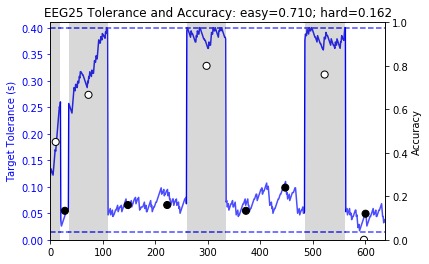

In [19]:
# Accuracy and Tolerance
f, ax1 = plt.subplots()
x = range(len(data))
plot_title = '{0} Tolerance and Accuracy: easy={1:0.3f}; hard={2:0.3f}'.format(
                SBJ, data[data['Condition']=='easy']['Hit'].mean(),
                data[data['Condition']=='hard']['Hit'].mean())
    
colors = {'easy': [0.5, 0.5, 0.5],#[c/255 for c in [77,175,74]],
          'hard': [1, 1, 1],#[c/255 for c in [228,26,28]],
          'accuracy': 'k'}#[c/255 for c in [55,126,184]]}
scat_colors = {'easy': [1,1,1],#[c/255 for c in [77,175,74]],
          'hard': [0,0,0]}
accuracy_colors = [scat_colors[accuracy.index[ix][1]] for ix in range(len(accuracy))]
#scale = {'Hit Total': np.max(data['Tolerance'])/np.max(data['Hit Total']),
#         'Score Total': np.max(data['Tolerance'])/np.max(data['Score Total'])}

ax1.plot(data['Tolerance'],'b',label='Tolerance')
ax1.plot(x,[prdm['tol_lim'][0] for _ in x],'b--')
ax1.plot(x,[prdm['tol_lim'][1] for _ in x],'b--')
ax1.set_ylabel('Target Tolerance (s)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim([0,len(data)])
ax1.set_ylim([0, 0.41])
ax1.set_facecolor('white')
ax1.grid(False)

ax2 = ax1.twinx()
# ax2.plot(data['Hit Total']/np.max(data['Hit Total']),'k',label='Hit Total')
ax2.fill_between(x, 1, 0, where=data['Condition']=='easy',
                facecolor=colors['easy'], alpha=0.3)#, label='hard')
ax2.fill_between(x, 1, 0, where=data['Condition']=='hard',
                facecolor=colors['hard'], alpha=0.3)#, label='easy')
ax2.scatter(block_mid_ix, accuracy, s=50, c=accuracy_colors,
           edgecolors='k', linewidths=1)#colors['accuracy'])#,linewidths=2)
ax2.set_ylabel('Accuracy', color=colors['accuracy'])
ax2.tick_params('y', colors=colors['accuracy'])
ax2.set_xlabel('Trials')
ax2.set_xlim([0,len(data)])
ax2.set_ylim([0, 1])
ax2.set_facecolor('white')
ax2.grid(False)

plt.title(plot_title)

plt.savefig(results_dir+'BHV/tolerance/'+SBJ+'_tolerance'+fig_type)

# Plot only real data (exclude examples + training)

In [54]:
data_all = data
# Exclude: Training/Examples, non-responses, first trial of each block
if data[data['RT']<0].shape[0]>0:
    print 'WARNING: '+str(data[data['RT']<0].shape[0])+' trials with no response!'
data = data[(data['Block']!=-1) & (data['RT']>0) & (data['ITI']>0)]

SyntaxError: invalid syntax (<ipython-input-54-e6212f0b4078>, line 4)

## Histogram of ITIs

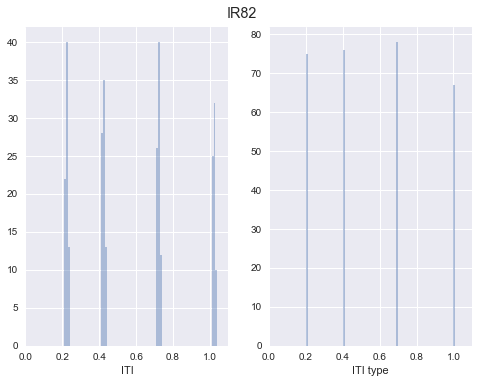

In [30]:
# ITI Histogram
f,axes = plt.subplots(1,2)
bins = np.arange(0,1.1,0.01)
hist_real = sns.distplot(data['ITI'],bins=bins,kde=False,label=SBJ,ax=axes[0])
hist_adj  = sns.distplot(data['ITI type'],bins=bins,kde=False,label=SBJ,ax=axes[1])
axes[0].set_xlim([0, 1.1])
axes[1].set_xlim([0, 1.1])
plt.subplots_adjust(top=0.93)
f.suptitle(SBJ)
plt.savefig(results_dir+'BHV/ITIs/'+SBJ+'_ITI_hist'+fig_type)

## Histogram of all RTs

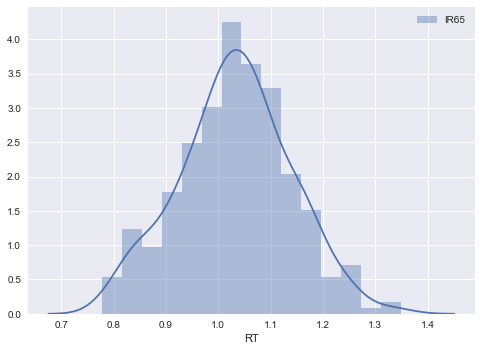

In [16]:
# RT Histogram
f,ax = plt.subplots()
hist = sns.distplot(data['RT'],label=SBJ)
plt.subplots_adjust(top=0.9)
hist.legend() # can also get the figure from plt.gcf()
plt.savefig(results_dir+'BHV/RTs/histograms/'+SBJ+'_RT_hist'+fig_type)

## RT Histograms by ITI

In [124]:
# ANOVA for RT differences across ITI
itis = np.unique(data['ITI type'])
if len(prdm['ITIs'])==4:
    f,iti_p = scipy.stats.f_oneway(data.loc[data['ITI type']==itis[0],('RT')].values,
                               data.loc[data['ITI type']==itis[1],('RT')].values,
                               data.loc[data['ITI type']==itis[2],('RT')].values,
                               data.loc[data['ITI type']==itis[3],('RT')].values)
elif len(prdm['ITIs'])==3:
    f,iti_p = scipy.stats.f_oneway(data.loc[data['ITI type']==itis[0],('RT')].values,
                               data.loc[data['ITI type']==itis[1],('RT')].values,
                               data.loc[data['ITI type']==itis[2],('RT')].values)
elif len(prdm['ITIs'])==2:
    f,iti_p = scipy.stats.ttest_ind(data.loc[data['ITI type']==itis[0],('RT')].values,
                               data.loc[data['ITI type']==itis[1],('RT')].values)
else:
    print 'WARNING: some weird paradigm version without 2, 3, or 4 ITIs!'
# print f, p

7.50997664622 7.38855835564e-05


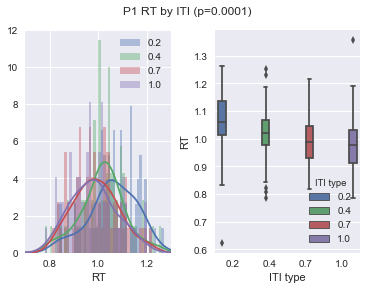

In [135]:
f, axes = plt.subplots(1,2)

# RT Histogram
rt_bins = np.arange(0.7,1.3,0.01)
for iti in itis:
    sns.distplot(data['RT'].loc[data['ITI type'] == iti],bins=rt_bins,label=str(round(iti,2)),ax=axes[0])
axes[0].legend() # can also get the figure from plt.gcf()
axes[0].set_xlim(min(rt_bins),max(rt_bins))

# Factor Plot
sns.boxplot(data=data,x='ITI type',y='RT',hue='ITI type',ax=axes[1])

# Add overall title
plt.subplots_adjust(top=0.9,wspace=0.3)
f.suptitle(SBJ+' RT by ITI (p='+str(round(iti_p,4))+')') # can also get the figure from plt.gcf()

# Save plot
plt.savefig(results_dir+'BHV/RTs/hist_ITI/'+SBJ+'_RT_ITI_hist_box'+fig_type)

## RT adjustment after being short vs. long

In [50]:
# t test for RT differences across ITI
itis = np.unique(data['ITI type'])
f,postlong_p = scipy.stats.ttest_ind(data.loc[data['postlong']==True,('dRT')].values,
                            data.loc[data['postlong']==False,('dRT')].values)

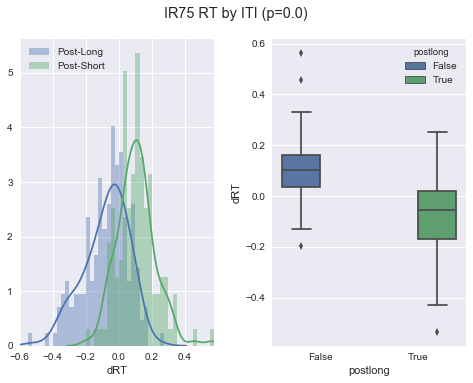

In [55]:
f, axes = plt.subplots(1,2)

# RT Histogram
drt_bins = np.arange(-0.6,0.6,0.025)
sns.distplot(data['dRT'].loc[data['postlong']==True],bins=drt_bins,label='Post-Long',ax=axes[0])
sns.distplot(data['dRT'].loc[data['postlong']==False],bins=drt_bins,label='Post-Short',ax=axes[0])
axes[0].legend() # can also get the figure from plt.gcf()
axes[0].set_xlim(min(drt_bins),max(drt_bins))

# Factor Plot
sns.boxplot(data=data,x='postlong',y='dRT',hue='postlong',ax=axes[1])

# Add overall title
plt.subplots_adjust(top=0.9,wspace=0.3)
f.suptitle(SBJ+' RT by ITI (p='+str(round(postlong_p,6))+')') # can also get the figure from plt.gcf()

# Save plot
plt.savefig(results_dir+'BHV/RTs/hist_dRT/'+SBJ+'_dRT_postlong_hist_box'+fig_type)

##RT and Accuracy Effects by ITI and across post-error

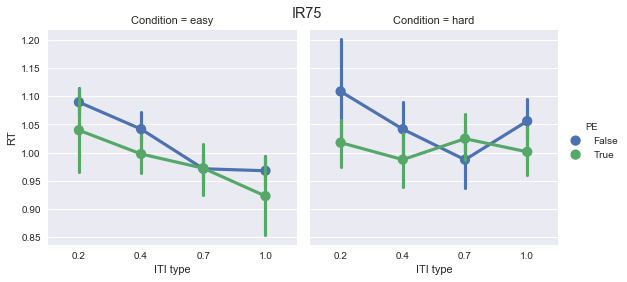

In [40]:
# RTs by condition
# if len(prdm_params['ITIs'])==4:    # target_time v1.8.5+
#     data['ITI type'] = ['short' if data['ITI'][ix]<0.5 else 'long' for ix in range(len(data))]
#     ITI_plot_order = ['short','long']
# elif len(prdm_params['ITIs'])==3:  # target_time v1.8.4 and below
#     data['ITI type'] = ['short' if data['ITI'][ix]<prdm_params['ITI_bounds'][0] else 'long' \
#                         if data['ITI'][ix]>prdm_params['ITI_bounds'][1] else 'medium'\
#                         for ix in range(len(data))]
#     ITI_plot_order = ['short','medium','long']
# else:               # Errors for anything besides len(ITIs)==3,4
#     assert len(prdm_params['ITIs'])==4

plot = sns.factorplot(data=data,x='ITI type',y='dRT',hue='PE',col='Condition',kind='point',
               ci=95);#,order=ITI_plot_order
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(SBJ) # can also get the figure from plt.gcf()

plt.savefig(results_dir+'BHV/RTs/hist_PE_ITI/'+SBJ+'_RT_PE_ITI_hit'+fig_type)

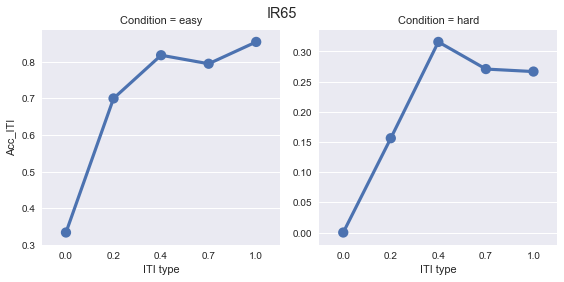

In [21]:
# WARNING: I would need to go across subjects to get variance in accuracy by ITI
plot = sns.factorplot(data=data,x='ITI type',y='Acc_ITI',col='Condition',kind='point',sharey=False,
               ci=95);#,order=ITI_plot_order
#plot.set(alpha=0.5)
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(SBJ) # can also get the figure from plt.gcf()

plt.savefig(results_dir+'BHV/accuracy/'+SBJ+'_acc_ITI'+fig_type)

## Look for behavioral adjustments following short and long responses

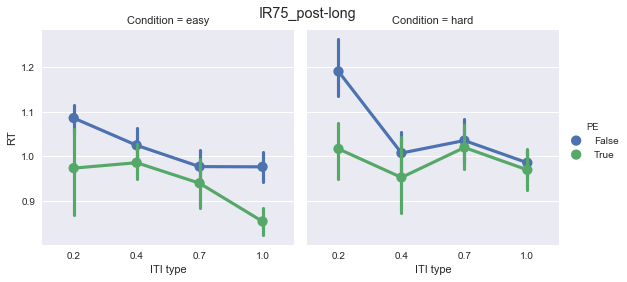

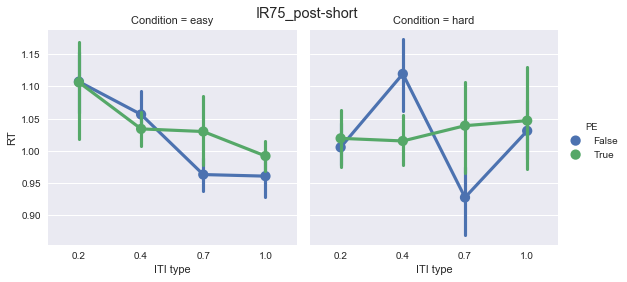

In [41]:
plot = sns.factorplot(data=data_PL,x='ITI type',y='RT',hue='PE',col='Condition',kind='point',
               ci=95,order=prdm['ITIs']);
plt.subplots_adjust(top=0.9)
plot.fig.suptitle(SBJ+'_post-long') # can also get the figure from plt.gcf()

# plt.savefig(results_dir+'RT_plots/'+SBJ+'_RT_PE_ITI_hit'+fig_type)
plot2 = sns.factorplot(data=data_PS,x='ITI type',y='RT',hue='PE',col='Condition',kind='point',
               ci=95,order=prdm['ITIs']);
plt.subplots_adjust(top=0.9)
plot2.fig.suptitle(SBJ+'_post-short') # can also get the figure from plt.gcf()

# plt.savefig(results_dir+'RT_plots/'+SBJ+'_RT_PE_ITI_hit'+fig_type)

# =================================================
# OLD SHIT
# =================================================

In [ ]:
# RT_means = {'short': np.empty(2),
#            'medium': np.empty(2),
#            'long': np.empty(2)}
# RT_cnt = {'short': np.empty(2),
#            'medium': np.empty(2),
#            'long': np.empty(2)}
# for ITI_type in ['short','medium','long']:
#     RT_means[ITI_type][0] = data.loc[(data['PE']==False) & (data['ITI type']==ITI_type),'RT'].mean()
#     RT_cnt[ITI_type][0] = sum([(data['PE']==False) & (data['ITI type']==ITI_type)]).sum()
#     RT_means[ITI_type][1] = data.loc[(data['PE']==True) & (data['ITI type']==ITI_type),'RT'].mean()
#     RT_cnt[ITI_type][1] = sum([(data['PE']==True) & (data['ITI type']==ITI_type)]).sum()
    
# print(ITI_type)
# print('PE: ',data.loc[data['PE']==True,'RT'].mean(),sum(data['PE']==True))
# print('PC: ',data.loc[data['PE']==False,'RT'].mean(),sum(data['PE']==False))

In [ ]:
# def makeECDF(sample):
#     def ECDF(x):
#         N = len(sample)
#         cumsum = sample<=x
#         CDF = np.sum(cumsum)/N
#         return CDF
#     return ECDF

# ecdf = makeECDF(sample)
# xs = np.linspace(0,1,len(sample))
# ys = [ecdf(x) for x in xs]
# plt.plot(xs,ys)
# sns.distplot(sample,rug=True,hist=False,kde=False)

In [36]:
# def makeECDF(sample):
#     def ECDF(x):
#         N = len(sample)
#         cumsum = sample<=x
#         CDF = np.sum(cumsum)/N
#         return CDF
#     return ECDF

# ecdf = makeECDF(data['Correct'])
# xs = np.linspace(0,1,len(data))
# ys = [ecdf(x) for x in xs]
# plt.plot(xs,ys)
